In [178]:
# Initialize Otter
import otter
grader = otter.Notebook("project_134.ipynb")

# Final Project 
    
## PSTAT 134 (Winter 2024) 
    
## Collaboration Policy 

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

In [179]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha D_{mi}(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user, $i = 1,2,\ldots, I$, $m = 1,\ldots,M$. (We won't discuss the role of $\alpha$ in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha D_{m1}\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha D_{m2}\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha D_{mI}\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (D_{m-}\circ\Gamma_{m-})^T v_m,
\end{aligned}
$$
where $I_{m-}$ and $\Gamma_{m-}$ are the $m$-th row of $\Gamma$ and $D$ (use the notation $\Gamma_{-i}$ for the $i$-th column). Hadamard product (elementwise matrix product) is denoted with $\circ$. When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha ((D_{m-}\circ\Gamma_{m-})^T V) \\
V^{\text{new}} &= V + 2\alpha ((D_{m-}\circ\Gamma_{m-}) U) \\
\end{aligned}
$$

<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [180]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    
    return R_ - np.dot(V_, np.transpose(U_))

def update_U(G_, U_, V_, alpha=0.01):
    
    return U_ + 2 * alpha * np.dot(np.nan_to_num(np.transpose(G_)), V_)

def update_V(G_, U_, V_, alpha=0.01):
    
    return V_ + 2 * alpha * np.dot(np.nan_to_num(G_), U_)

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [181]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [182]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [183]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R*Rone, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R*Rone, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index= Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index= Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [184]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [185]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [186]:
## TEST ##
output2['U'].shape

(5, 8)

In [187]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [188]:
## TEST ##
output2['V'].shape

(7, 8)

In [189]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [190]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [191]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [192]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [193]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

fig_rmse : The figure is showing the calculated rmse, how spread the residuals are, over iterations. It will give us an understanding of the model error, here we are seeing the decrease in RMSE as the amount of iterations increases which is what we are looking for. It's telling us the fit of the model to observed ratings is improving as more iterations occur, in other words, model accuracy and precision is getting better. The RMSE starts off high because we begin with random estimates.

fig_max_residual_change: For this figure we are seeing the model maximum residual change over iterations, the residuals are the difference between the observed and predicted ratings. In this case we are seeing a decreasing pattern as more and more iterations occur, so the max residual change is getting smaller. This means the model is stabilizing as the change in residuals is becoming less over time, fewer changes are being made to the estimated values which tells us the model is becoming more consistent.

fig_updates: Maximum relative update of U and V over iterations, we do see a decreasing pattern as there are less max update peaks occuring after the first 500 iterations and it reaches a constant pattern where it can be infered that the model has stabilized and is consistent. That is a good sign since it tells us the model nearing optimization.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [194]:
# run on larger dataset
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack()[100:]

np.random.seed(134) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [195]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

/tmp/ipykernel_73/1847306426.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ], axis=1).stack().dropna().reset_index()[['fit','observed']]


alt.Chart(...)

**Question**: Consider the above plot.
- By reading the code, comment on what the plot is illustrating. 
- What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

In [196]:
alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    counts=True,
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

The plot is illustrating the density distribution of fitted ratings vs observed ratings. Each graph represents a different observed rating 1-5 and the value of fitted rating is represented in the x-axis and the density for each value is on the y-axis. We can see that most observed ratings density graphs are normally distributed.
When you add counts=True to transform_density, the graph will instead show the number of observations within each bin rather than the density for fitted ratings so rather than density distribution we will get a frequency distribution.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

In [197]:
user_601 = Rhatbig.iloc[:,601]
recommended_601 = user_601.sort_values(ascending=False)
print(recommended_601.head(5))

movie id  movie title                               
174       Raiders of the Lost Ark (1981)                17.655701
172       Empire Strikes Back, The (1980)                9.984398
204       Back to the Future (1985)                      7.846455
1177      Dunston Checks In (1996)                       6.989592
1240      Ghost in the Shell (Kokaku kidotai) (1995)     6.892020
Name: (rating, 602), dtype: float64


For user 601 I would recommend "Raiders of the Lost Ark" (1981), "The Empire Strikes Back" (1980), "Back to the Future" (1985), "Dunston Checks In" (1996), and "Ghost in the Shell" (Kokaku kidotai) (1995) as the top five movies in that order.
Yes, there are similarities to the movies the user rated high. They primarily liked movies with the genres action, adventure, and sci fi.

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
D_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I D_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|_2^2 + \sum_{m=1}^{M}\|v_m\|_2^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

$$
\begin{aligned}
U^{\text{new}} &= U - \alpha (-2(R-VU^T)^T V + 2\lambda(U)) \\
V^{\text{new}} &= V - \alpha (-2(R-VU^T) U + 2\lambda(V)) \\
\end{aligned}
$$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [198]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_):
    
    return R_ - np.dot(V_, np.transpose(U_))

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    gradient_U = -2 * np.dot(np.nan_to_num(np.transpose(G_)), V_) + 2 * lam * U_
    
    return U_ - alpha * gradient_U

def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    gradient_V = -2 * np.dot(np.nan_to_num(G_), U_) + 2 * lam * V_
    
    return V_ - alpha * gradient_V

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)

In [199]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [200]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G, U, V, lam, alpha)
        Gnew = update_G_reg(R*Rone, Unew, V)

        Vnew = update_V_reg(Gnew, Unew, V, lam, alpha)
        Gnew = update_G_reg(R*Rone, Unew, Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=Rdf.columns, columns=kindex)
    V = pd.DataFrame(V, index=Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [201]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [202]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=20, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=20, lam=5.0, alpha=0.001)

In [263]:
output_noreg['U'].shape
output_noreg['U'].index
output_noreg['U'].columns
U_noreg = output_noreg['U']

output_reg['U'].shape
output_reg['U'].index
output_reg['U'].columns
U_reg = output_reg['U']

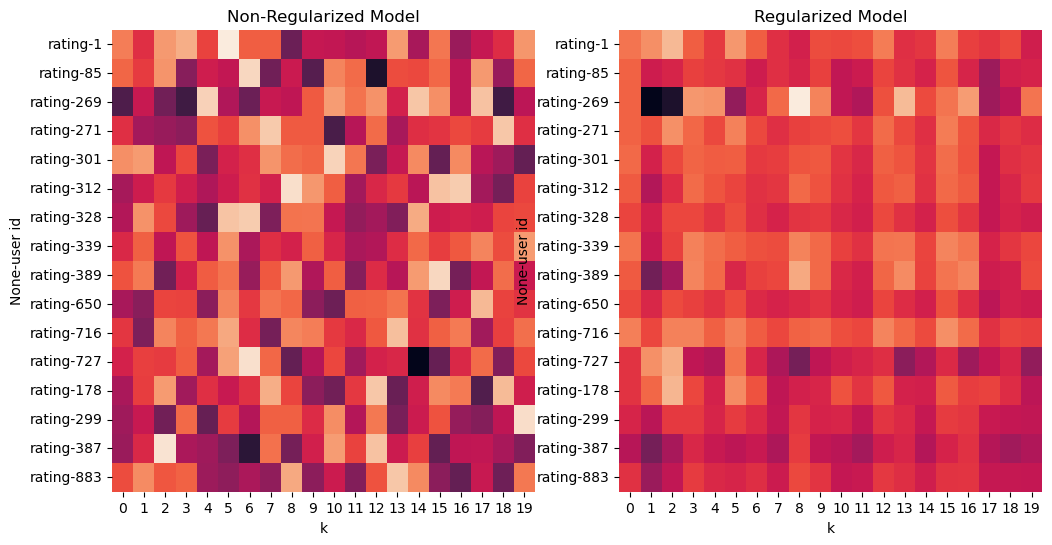

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(U_noreg, cbar=False)
plt.title('Non-Regularized Model')

plt.subplot(1, 2, 2)
sns.heatmap(U_reg, cbar=False)
plt.title('Regularized Model')
plt.show()


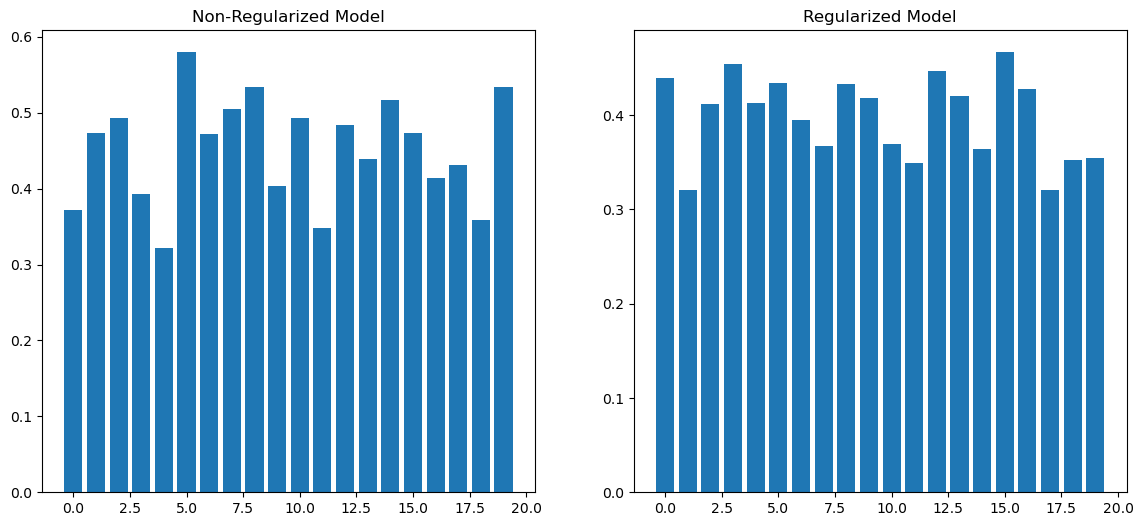

In [205]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(range(U_noreg.shape[1]), height = U_noreg.mean(axis=0))
plt.title('Non-Regularized Model')

plt.subplot(1, 2, 2)
plt.bar(range(U_reg.shape[1]), height = U_reg.mean(axis=0))
plt.title('Regularized Model')
plt.show()


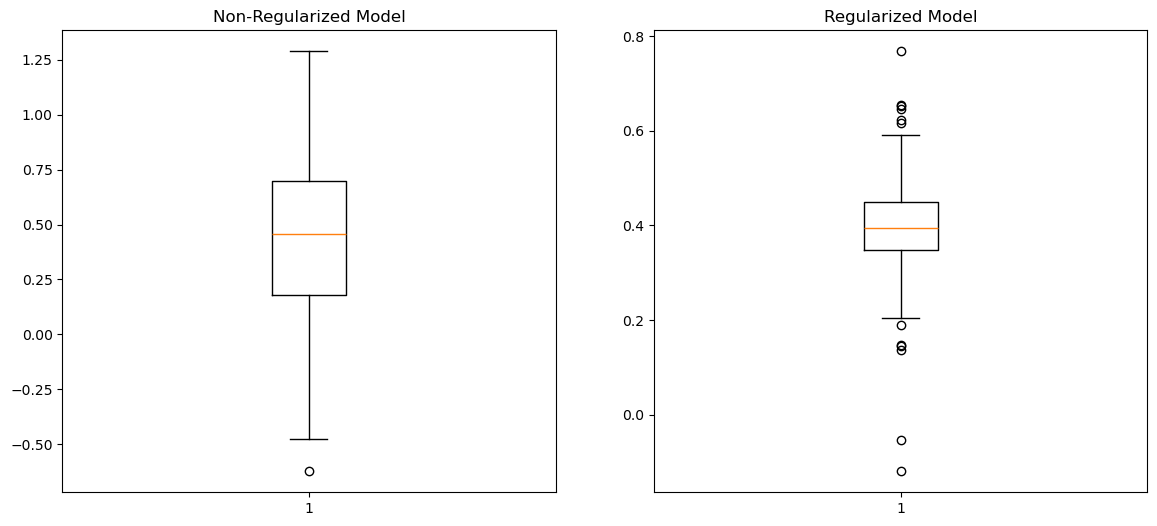

In [206]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.boxplot(U_noreg.values.flatten())
plt.title('Non-Regularized Model')

plt.subplot(1, 2, 2)
plt.boxplot(U_reg.values.flatten())
plt.title('Regularized Model')
plt.show()

Regularization vs Non-regularization
Looking at the heatmap right away we notice that for the regularized model it is more smooth overall and the color intensity is more balanced, there is less of a presence of extremely dark or light values which makes sense as regularization's goal is stabilize the model and stay away from extreme values, less variability.
Next we have the bar plot, in the regularized model the bar heights have a smaller range difference in comparison to the unregularized model. The smaller differences in bar heights is showing how regularization is scaling the model to be more consistent and thus improving generalization while the nonregularized model is more variable.
Our third visualization is the box plot, similarily to the other visualizations we can see a smaller spread of data of the regularization model. The box which represents the IQR of value distribution is considerably smaller than the non-regularized model one so the 25th to 75th data percentile is much more dense as they are closer to one another. Furthermore, looking at the whiskers, the regularized model has a smaller reach meaning we have a larger minimum and smaller maximum. This all tells us the regularized model is reducing data spread which decreases variance and removes complexity to help with overfitting.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported **by evidence**, such as code implementation and results.

**SOLUTION**

In [207]:

def update_k(Rdf, K_values, lambda_value=5.0, alpha=0.001, max_iteration=5000):
    results = {}

    for K in K_values:
        output = compute_UV_reg(Rdf, K=K, lam=lambda_value, alpha=alpha, max_iteration=max_iteration)
        results[K] = output['rmse']

    return results

K_values = [5, 10, 15, 20, 25, 30] 

def update_lambda(Rdf, lambda_values, K_value = 20, alpha=0.001, max_iteration=5000):
    results = {}

    for lam in lambda_values:
        output = compute_UV_reg(Rdf, lam=lam, K=K_value, alpha=alpha, max_iteration=max_iteration)
        results[lam] = output['rmse']

    return results
lambda_values = [0.1 ,1.0, 5.0, 10.0, 15.0]  # Experiment with different values of lambda

# Perform experiments
k_rmse = update_k(Rsmall, K_values)
lambda_rmse = update_lambda(Rsmall, lambda_values)

In [208]:
print(k_rmse[30])
print(k_rmse[25])
print(k_rmse[20])
print(k_rmse[10])
print(k_rmse[5])

     iteration      rmse  max residual change
0            0  2.805573             1.783747
1            1  2.062546             1.094210
2            2  1.594024             0.750113
3            3  1.290219             0.544046
4            4  1.093264             0.410382
..         ...       ...                  ...
705        705  0.910393             0.000076
706        706  0.910400             0.000076
707        707  0.910407             0.000076
708        708  0.910414             0.000076
709        709  0.910421             0.000075

[710 rows x 3 columns]
     iteration      rmse  max residual change
0            0  2.007447             1.336697
1            1  1.617004             0.905890
2            2  1.363514             0.648870
3            3  1.198268             0.483379
4            4  1.091111             0.370785
..         ...       ...                  ...
743        743  0.911193             0.000049
744        744  0.911197             0.000049
745       

While keeping lambda constant and experimenting with different K values, I noticed that both lowering and increasing the K value from 20 increased the rmse. K affects complexity of the model, so lower K would make the model more prone to overfitting and also increasing K to a too high of a value would also cause overfitting as the model can fit noise in the data instead of patterns.

In [209]:
print(lambda_rmse[15])
print(lambda_rmse[10])
print(lambda_rmse[5])
print(lambda_rmse[1])
print(lambda_rmse[0.1])

     iteration      rmse  max residual change
0            0  1.272112             1.043471
1            1  1.059526             0.765135
2            2  0.974675             0.585174
3            3  0.965286             0.461561
4            4  0.994038             0.372734
..         ...       ...                  ...
177        177  1.682723             0.000037
178        178  1.682727             0.000035
179        179  1.682730             0.000034
180        180  1.682733             0.000032
181        181  1.682736             0.000031

[182 rows x 3 columns]
     iteration      rmse  max residual change
0            0  1.361629             0.736390
1            1  1.196961             0.559986
2            2  1.104400             0.439155
3            3  1.057574             0.352638
4            4  1.038590             0.288518
..         ...       ...                  ...
284        284  1.297237             0.000072
285        285  1.297245             0.000072
286       

While keeping K constant and experimenting with different lambda values, I found that lambda=1 produced the best rmse. Increasing and decreasing lambda from the initial value of 5 with K=20 caused the rmse to both increase and decrease, this is because increasing lambda to a high value can decrease variance and lower overfitting, but it will greatly increase bias in the model as well as lower model flexibility. Too low of a lambda is not something you want because you are still trying to lower variance.

Since we knew K=20 was the best K value for us through looking at rmse, we experiment with different values of lambda with this constant K that would then also have the lowest rmse among all the lambda values tested.

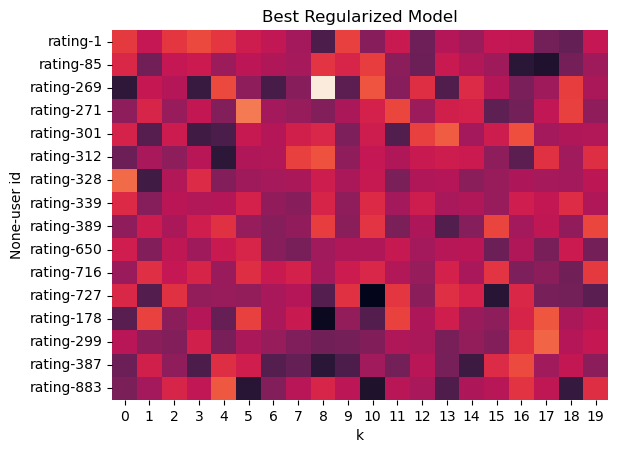

In [309]:
best_output_reg = compute_UV_reg(Rsmall, K=20, lam=1.0, alpha=0.001)
best_U_reg = best_output_reg['U']

sns.heatmap(best_U_reg, cbar=False)
plt.title('Best Regularized Model')
plt.show()

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

Note: In this part, 
- Creating a new data `Rmedium` by `ratings_stacked.pkl` and `Rsmall`,
    1. Loading `rantings_stacked.pkl` and adding the `user id` having less than 134 NA's in it to `user id` in `Rsmall`,
    2. Adding movies with `movie id` $134-234$ to `movie id` in `Rsmall`,
    3. Name the new dataset as `Rmedium` and use `Rmedium` to do clustering.
- Using the 'best' model you select in Question 2e to compute `UVstd`.

**SOLUTION**

In [310]:
np.random.seed(134) # set seed for tests
ratings_stacked = pd.read_pickle('data/ratings_stacked.pkl').unstack()

na_ratings = ratings_stacked.isnull().sum(axis=0)
selected_users = na_ratings[na_ratings < 134].index
filter = ratings_stacked.loc[selected_users]

movie_ids = range(134, 235)
movie_ids_stacked = ratings_stacked.loc[movie_ids]

Rsmall_ids = pd.concat([Rsmall, movie_ids_stacked])
Rmedium = pd.concat([filter, Rsmall_ids], axis=1)


In [301]:
best_output_reg = compute_UV_reg(Rmedium, K=20, lam=1.0, alpha=0.001)
best_U_reg = best_output_reg['U']
best_V_reg = best_output_reg['V'] 

from sklearn.preprocessing import StandardScaler

U_std = StandardScaler().fit_transform(best_U_reg)
V_std = StandardScaler().fit_transform(best_V_reg)

UVstd = np.concatenate((U_std, V_std), axis=0)

In [302]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=5)
hierarchical_labels = hierarchical_cluster.fit_predict(UVstd)


In [303]:
from sklearn.cluster import KMeans

kmeans_labels = KMeans(n_clusters=5, random_state=0).fit_predict(UVstd)

True labels are not known so clustering methods I will be using are Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index.

In [304]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_hierarchical = silhouette_score(UVstd, hierarchical_labels)
silhouette_kmeans = silhouette_score(UVstd, kmeans_labels)
print(silhouette_hierarchical)
print(silhouette_kmeans)

calinski_harabasz_hierarchical = calinski_harabasz_score(UVstd, hierarchical_labels)
calinski_harabasz_kmeans = calinski_harabasz_score(UVstd, kmeans_labels)
print(calinski_harabasz_hierarchical)
print(calinski_harabasz_kmeans)

davies_bouldin_hierarchical = davies_bouldin_score(UVstd, hierarchical_labels)
davies_bouldin_kmeans = davies_bouldin_score(UVstd, kmeans_labels)
print(davies_bouldin_hierarchical)
print(davies_bouldin_kmeans)

0.5248348219818862
0.5327258037593081
318.24610038671807
349.754271163516
3.5114883142141027
3.045376985566975


The Silhouette Coefficient is used to find the separation distance between clusters, so a measure of how close each point in one cluster is to another cluster with a range of [-1,1]. Negative values imply the value is assigned to the wrong cluster, near 1 tells us the clusters are far from neighboring clusters, and near 0 means clusters are close to one another. In this case, the kmeans has a higher silhouette coefficient than the hierarchical method so kmean clusters are farther from one another. 

Calinski-Harabasz Index measures how similar a point is to its own cluster compared to other clusters. It calculates the distance from a data point to its own cluster centroid and then the distance from that cluster centroid to the global centroid. A higher value would mean that the clusters are well separated, more dense,and better defined, again in this case the kmeans has the higher number.

Davies-Bouldin Index calculates the similarity between a cluster and it's most similar cluster in the model, clusters with the closest distance. Here a lower score index is desirable as the Davies-Bouldin Index is the average similarity of clusters so a smaller number would mean lower average, clusters are well-separated from one another and compact. Looking at kmeans and hierarchical, kmeans has the lower score so again kmeans has the better clustering performance.

For our problem we are qualitatively inspecting users and movies in the cluster and deciding on a representative movie for each cluster so each cluster is a variation of user preference. This means that each cluster is distinctly different so we would therefore choose the metrics that detail cluster separation and distance. Through the cluster validation methods, kmeans proved to be better in the context we are looking for. Out of the three metrics we chose, they were very similar to one another in telling cluster separation however I would choose Calinski-Harabasz Index as it both looks for an objects relation within it's own cluster and then the relation to outside clusters, between and within cluster dispersion.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [305]:
# install umap
# !pip install umap-learn

In [306]:
#!pip install cython
#!pip install numpy scipy
#!pip install scikit-learn
#!pip install hdbscan

In [307]:
import umap
import hdbscan
import sklearn.cluster as cluster

In [ ]:
umap_reducer = umap.UMAP(n_components=2)
umap_projection = umap_reducer.fit_transform(UVstd)

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.scatter(umap_projection[kmeans_labels == i, 0], umap_projection[kmeans_labels == i, 1], label=f'Cluster {i+1}')

plt.title('K-means Clustering (2D UMAP)')
plt.legend()
plt.show()

Yes the clusters and Umap projection is consistent as in terms of cluster metric performance. We didn't get the best scores in our performance metrics such as for the Silhouette Coefficient. A near one number is ideal while we achieved a score of around 0.5 for both clustering methods and for Davies Bouldin Index a near zero score would indicate a great clustering model but we recieved values above 3. In the UMAP we can see an area where most of the clusters are very close to one another, even overlapping, while the orange cluster is the outlier being much farther away from the rest.

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)